# ML Assignment 2 & 3   
# Paul Thillen, Louis-Philippe Noël
# 3. PRACTICAL PART (40 pts) : Neural network implementation and experiments

## Numerically stable softmax. 
You will need to compute a numerically
stable softmax. Refer to posted readings to see how to do this. Start by
writing the expression for a single vector, then adapt it for a mini-batch
of examples stored in a matrix.


In [2]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.io
import gzip,pickle
import copy
import math

Populating the interactive namespace from numpy and matplotlib


#Load data

In [3]:
#two moons 
two_moons = np.loadtxt(open('2moons.txt','r'))
#mnist
f=gzip.open('mnist.pkl.gz')
mnist=pickle.load(f)

#Utilities

In [4]:
def softmax(x):
    maximum = np.max(x, axis=-1, keepdims=True)
    top = np.exp(x - maximum)
    bottom = np.sum(top, axis=-1, keepdims=True)
    return top/bottom

#test
#A= array([[ 1.,  3.,  4.,  5.,  6.],
#       [ 4.,  5.,  6.,  3.,  3.],
#       [ 1.,  3.,  4.,  5.,  6.],
#       [ 4.,  5.,  6.,  3.,  3.]])
#softmax(A)

In [5]:
def uniforme(a,b):
    return(a+(b-a)*np.random.rand()) 

## Parameter initialization. 
As you know, it is necessary to randomly
initialize the parameters of your neural network (trying to avoid symme-
try and saturating neurons, and ideally so that the pre-activation lies in
the bending region of the activation function so that the overall networks
acts as a non linear function). We suggest that you sample the weights
of a layer from a uniform distribution in [ -1/sqrt(n_c), 1/sqrt(n_c) ], 
where n c is the number of inputs for this layer (changing from one layer to the other).
Biases can be initialized at 0. Justify any other initialization method.

## fprop
fprop will compute the forward progpagation i.e. step by step computation from the input to the output and the cost of the activations of each layer.

## bprop
bprop will use the computed activations by fprop and does
the backpropagation of the gradients from the cost to the input following
precisely the steps derived in part 2.

## Finite difference gradient check. We can estimate the gradient nu-
merically using the finite difference method. You will implement this estimate as a tool to check your gradient computation. To do so, calculate the value of the loss function for the current parameter values (for a single example or a mini batch). Then for each scalar parameter θ k , change the
parameter value by adding a small perturbation (10^−6 < ε < 10^−4 )
and calculate the new value of the loss (same example or minibatch),
then set the value of the parameter back to its original value. The partial
derivative with respect to this parameter is estimated by dividing the
change in the loss function by ε. The ratio of your gradient computed
by backpropagation and your estimate using finite difference should be
between 0.99 and 1.01.

All in one : Class

In [17]:
class Model:

    def plot_function(self, train_data, title):
        plt.figure()
        d1 = train_data[train_data[:, -1] > 0]
        d2 = train_data[train_data[:, -1] == 0]
        plt.scatter(d1[:, 0], d1[:, 1], c='b', label='classe 1')
        plt.scatter(d2[:, 0], d2[:, 1], c='g', label='classe 0')
        #x = np.linspace(np.min(train_data[:, 0]) - 0.5,
        #                np.max(train_data[:, 0]) + 0.5,
        #               100)
        #y = -(self.w2[0]*x + self.b2 - .5)/self.w2[1]
        #plt.plot(x, y, c='r', lw=2, label='y = -(w1*x + b1)/w2')
        plt.xlim(np.min(train_data[:, 0]) - 0.5, np.max(train_data[:, 0]) + 0.5)
        plt.ylim(np.min(train_data[:, 1]) - 0.5, np.max(train_data[:, 1]) + 0.5)
        plt.grid()
        plt.legend(loc='lower right')
        plt.title(title)
        plt.show()

In [18]:
class neural_net(Model):
    
    def __init__(self, nc, m, k):
        #nc : number of neurons in the hidden layer
        #m : number of classes
        #k : size of mini-batches to use
        self.nc = nc
        self.m = m
        self.k = k
        
        
    def train(self,train_data, max_iter = 100, mu = 0.02, lamba = 0):
        self.lamba = lamba
        #print("x shape",self.x.shape)
        self.train_data = train_data
        #self.b1=np.zeros((self.nc,self.train_data.shape[1]-1))
        #self.b2=np.zeros((self.m,self.train_data.shape[1]-1))
        self.b1=np.zeros((self.nc,1))
        self.b2=np.zeros((self.m,1))
        self.nc1 = self.train_data.shape[1]-1
        self.nc2 = self.nc
        self.w1 = np.multiply(np.ones((self.nc,self.nc1)),uniforme(-1/sqrt(self.nc1),1/sqrt(self.nc1)))
        #print(self.nc,self.nc1)
        self.w2 = np.multiply(np.ones((self.m,self.nc)),uniforme(-1/sqrt(self.nc2),1/sqrt(self.nc2)))
        print("w1:",self.w1)
        print("w2:",self.w2)
        print("b1:",self.b1)
        print("b2:",self.b2)
        
        #gradient descent
        for i in range(max_iter):
            for j in range(int(math.ceil(train_data.shape[0]/float(self.k)))):
                print("intervalle j",int(math.ceil(train_data.shape[0]/self.k)))
                print("j",j)
                #set x and y according to mini-batch size
                self.x = np.transpose(train_data[j*self.k:(j+1)*self.k,:-1])
                self.y = np.transpose(train_data[j*self.k:(j+1)*self.k,-1])
                print("x",self.x)
                #calculate gradients with this minibatch
                self.fprop()
                self.bprop()
                
                #Calcul de la moyenne des gradients de tous les exemples de la mini-batch
                self.grad_w1 = np.mean(self.grad_w1, axis=0)
                self.grad_w2 = np.mean(self.grad_w2, axis=0)
                self.grad_b1 = np.mean(self.grad_b1, axis=0)
                self.grad_b2 = np.mean(self.grad_b2, axis=0)
                
                #mise à jour des paramètres
                self.w1 -= mu * self.grad_w1_el
                self.b1 -= mu * self.grad_b1
                self.w2 -= mu * self.grad_w2_el
                self.b2 -= mu * self.grad_b2
                
                #to remove
                print("w1:",self.w1)
                print("b1:",self.b1)
                print("w2:",self.w2)
                print("b2:",self.b2)
        
    def fprop(self):
        #ha : activation des neurones de la couche cachée
        self.ha= np.add(np.dot(self.w1,self.x),self.b1)
        #print(np.dot(self.w1,self.x))
        #print("ha:",self.ha)
        #print("b1:",self.b1, self.b1.shape)
        print("ha", self.ha.shape)
        #hs : sortie des neurones de la couche cachée
        self.hs= np.maximum(0,self.ha)
        print("hs", self.hs.shape)
        print("w2", self.w2.shape)
        #oa : activation des neurones de la couche de sortie
        self.oa= np.add(np.dot(self.w2,self.hs),self.b2)
        print("oa", self.oa.shape)
        #os : sortie des neurones de la couche cachée
        self.os=softmax(self.oa)
        print("os", self.os.shape)
        #L : fonction de coût
        self.L= -np.log(self.os)
        print("L", self.L.shape)
        #print(self.L)
        return self.L
    
    def bprop(self):
        #grad_oa : gradient de la fonction d'activation de la couche de sortie par rapport à L
        onehot=np.zeros((self.m,self.x.shape[1]))
        onehot[np.int_(self.y)-1]=1
        self.grad_oa = self.os-onehot
        print("grad oa",self.grad_oa.shape)
        #grad_w2 et grad_b2
        self.grad_w2 = np.dot(self.grad_oa,np.transpose(self.hs))
        print("grad w2",self.grad_w2.shape)
        self.grad_b2 = np.sum(self.grad_oa, axis=1, keepdims=True)
        print("grad b2",self.grad_b2.shape)
        #grad_hs
        self.grad_hs = np.dot(np.transpose(self.w2),self.grad_oa)
        print("grad hs",self.grad_hs.shape)
        #grad_ha
        def I_ha(x):
            #x is a vector
            y=np.zeros((len(x),1))
            for i in range(0, len(x)):
                    if x[i,0]>0:
                        y[i,0] = 1
                    else:
                        y[i,0]=0
            return y

        self.grad_ha = np.multiply(self.grad_hs,I_ha(self.ha))
        print("grad ha",self.grad_ha.shape)
        #grad_w1 et grad_b1
        self.grad_w1 = np.dot(self.grad_ha,np.transpose(self.x))
        print("grad w1",self.grad_w1.shape)
        self.grad_b1 = np.sum(self.grad_ha, axis=1, keepdims=True)
        print("grad b1",self.grad_b1.shape)
        #grad_x
        self.grad_x = np.dot(np.transpose(self.w1),self.grad_ha)
        print("grad x",self.grad_x.shape)
        #elastic regularization
        self.grad_w2_el = self.grad_w2-self.lamba*(2*self.w2+np.sign(self.w2))
        print("grad w2 el",self.grad_w2_el.shape)
        self.grad_w1_el = self.grad_w1-self.lamba*(2*self.w1+np.sign(self.w1))
        print("grad w1 el",self.grad_w1_el.shape)
        
    #check if slightly changed parameters yield a similar gradient
    def finite_check(self):
        e = 0.00002
        #copier le réseau actuel et 
        self.net_copy = copy.copy(self)
        self.net_copy.w1 = np.add(self.w1,e)
        self.net_copy.w2 = np.add(self.w2,e)
        self.net_copy.b1 = np.add(self.b1,e)
        self.net_copy.b2 = np.add(self.b2,e)
        #gradients avec nouvelles valeurs des paramètres
        self.net_copy.fprop()
        self.net_copy.bprop()
        #check difference
        ratio_w1 = np.divide(self.grad_w1_el,self.net_copy.grad_w1_el)
        #print ratio_w1
        ratio_w2 = np.divide(self.grad_w2_el,self.net_copy.grad_w2_el)
        #print ratio_w2
        ratio_b1 = np.divide(self.grad_b1,self.net_copy.grad_b1)
        #print ratio_b1
        ratio_b2 = np.divide(self.grad_b2,self.net_copy.grad_b2)
        #print ratio_b2
        ratios = [ratio_w1,ratio_w2,ratio_b1,ratio_b2]
        #sortie
        for ratio in ratios:
            if (ratio<0.99).any() or (ratio>1.01).any():
                return False
        return True

 ## Size of the mini batches. 
We ask that your computation and gradient descent is done on minibatches (as opposed to the whole training set)
with adjustable size using a hyperparameter K. In the minibatch case,
we do not manipulate a single input vector, but rather a batch of input
vectors grouped in a matrix (that will give a matrix representation at
each layer, and for the input). In the case where the size is one, we obtain
an equivalent to the stochastic gradient. Given that numpy is eﬃcient on
matrix operations, it is more eﬃcient to perform computations on a whole
minibatch. It will greatly impact the execution time.

1. As a beginning, start with an implementation that computes the gradients
for a single example, and check that the gradient is correct using the ﬁnitediﬀerence method described above.

In [11]:
#exemple x : 3 neurones cachés, 2 dimensions, classe = 2
x= np.array([[1.2084724, 0.39429077, 1.]])
net1 = neural_net(2,2,100)
net1.train(x)
net1.fprop()
net1.bprop()
net1.finite_check()

('w1:', array([[-0.46555689, -0.46555689],
       [-0.46555689, -0.46555689]]))
('w2:', array([[ 0.69572629,  0.69572629],
       [ 0.69572629,  0.69572629]]))
('b1:', array([[ 0.],
       [ 0.]]))
('b2:', array([[ 0.],
       [ 0.]]))
('intervalle j', 0)
('j', 0)
('x', array([[ 1.2084724 ],
       [ 0.39429077]]))
('ha', (2L, 1L))
('hs', (2L, 1L))
('w2', (2L, 2L))
('oa', (2L, 1L))
('os', (2L, 1L))
('L', (2L, 1L))
('grad oa', (2L, 1L))
('grad w2', (2L, 2L))
('grad b2', (2L, 1L))
('grad hs', (2L, 1L))
('grad ha', (2L, 1L))
('grad w1', (2L, 2L))
('grad b1', (2L, 1L))
('grad x', (2L, 1L))
('grad w2 el', (2L, 2L))
('grad w1 el', (2L, 2L))
('w1:', array([[-0.46555689, -0.46555689],
       [-0.46555689, -0.46555689]]))
('b1:', array([[ 0.],
       [ 0.]]))
('w2:', array([[ 0.69572629,  0.69572629],
       [ 0.69572629,  0.69572629]]))
('b2:', array([[-0.01],
       [-0.01]]))
('intervalle j', 0)
('j', 0)
('x', array([[ 1.2084724 ],
       [ 0.39429077]]))
('ha', (2L, 1L))
('hs', (2L, 1L))
('

('b2:', array([[-0.21],
       [-0.21]]))
('intervalle j', 0)
('j', 0)
('x', array([[ 1.2084724 ],
       [ 0.39429077]]))
('ha', (2L, 1L))
('hs', (2L, 1L))
('w2', (2L, 2L))
('oa', (2L, 1L))
('os', (2L, 1L))
('L', (2L, 1L))
('grad oa', (2L, 1L))
('grad w2', (2L, 2L))
('grad b2', (2L, 1L))
('grad hs', (2L, 1L))
('grad ha', (2L, 1L))
('grad w1', (2L, 2L))
('grad b1', (2L, 1L))
('grad x', (2L, 1L))
('grad w2 el', (2L, 2L))
('grad w1 el', (2L, 2L))
('w1:', array([[-0.46555689, -0.46555689],
       [-0.46555689, -0.46555689]]))
('b1:', array([[ 0.],
       [ 0.]]))
('w2:', array([[ 0.69572629,  0.69572629],
       [ 0.69572629,  0.69572629]]))
('b2:', array([[-0.22],
       [-0.22]]))
('intervalle j', 0)
('j', 0)
('x', array([[ 1.2084724 ],
       [ 0.39429077]]))
('ha', (2L, 1L))
('hs', (2L, 1L))
('w2', (2L, 2L))
('oa', (2L, 1L))
('os', (2L, 1L))
('L', (2L, 1L))
('grad oa', (2L, 1L))
('grad w2', (2L, 2L))
('grad b2', (2L, 1L))
('grad hs', (2L, 1L))
('grad ha', (2L, 1L))
('grad w1', (2L, 2L

('grad b1', (2L, 1L))
('grad x', (2L, 1L))
('grad w2 el', (2L, 2L))
('grad w1 el', (2L, 2L))
('w1:', array([[-0.46555689, -0.46555689],
       [-0.46555689, -0.46555689]]))
('b1:', array([[ 0.],
       [ 0.]]))
('w2:', array([[ 0.69572629,  0.69572629],
       [ 0.69572629,  0.69572629]]))
('b2:', array([[-0.44],
       [-0.44]]))
('intervalle j', 0)
('j', 0)
('x', array([[ 1.2084724 ],
       [ 0.39429077]]))
('ha', (2L, 1L))
('hs', (2L, 1L))
('w2', (2L, 2L))
('oa', (2L, 1L))
('os', (2L, 1L))
('L', (2L, 1L))
('grad oa', (2L, 1L))
('grad w2', (2L, 2L))
('grad b2', (2L, 1L))
('grad hs', (2L, 1L))
('grad ha', (2L, 1L))
('grad w1', (2L, 2L))
('grad b1', (2L, 1L))
('grad x', (2L, 1L))
('grad w2 el', (2L, 2L))
('grad w1 el', (2L, 2L))
('w1:', array([[-0.46555689, -0.46555689],
       [-0.46555689, -0.46555689]]))
('b1:', array([[ 0.],
       [ 0.]]))
('w2:', array([[ 0.69572629,  0.69572629],
       [ 0.69572629,  0.69572629]]))
('b2:', array([[-0.45],
       [-0.45]]))
('intervalle j', 0)


('grad hs', (2L, 1L))
('grad ha', (2L, 1L))
('grad w1', (2L, 2L))
('grad b1', (2L, 1L))
('grad x', (2L, 1L))
('grad w2 el', (2L, 2L))
('grad w1 el', (2L, 2L))
('w1:', array([[-0.46555689, -0.46555689],
       [-0.46555689, -0.46555689]]))
('b1:', array([[ 0.],
       [ 0.]]))
('w2:', array([[ 0.69572629,  0.69572629],
       [ 0.69572629,  0.69572629]]))
('b2:', array([[-0.64],
       [-0.64]]))
('intervalle j', 0)
('j', 0)
('x', array([[ 1.2084724 ],
       [ 0.39429077]]))
('ha', (2L, 1L))
('hs', (2L, 1L))
('w2', (2L, 2L))
('oa', (2L, 1L))
('os', (2L, 1L))
('L', (2L, 1L))
('grad oa', (2L, 1L))
('grad w2', (2L, 2L))
('grad b2', (2L, 1L))
('grad hs', (2L, 1L))
('grad ha', (2L, 1L))
('grad w1', (2L, 2L))
('grad b1', (2L, 1L))
('grad x', (2L, 1L))
('grad w2 el', (2L, 2L))
('grad w1 el', (2L, 2L))
('w1:', array([[-0.46555689, -0.46555689],
       [-0.46555689, -0.46555689]]))
('b1:', array([[ 0.],
       [ 0.]]))
('w2:', array([[ 0.69572629,  0.69572629],
       [ 0.69572629,  0.69572629]

('oa', (2L, 1L))
('os', (2L, 1L))
('L', (2L, 1L))
('grad oa', (2L, 1L))
('grad w2', (2L, 2L))
('grad b2', (2L, 1L))
('grad hs', (2L, 1L))
('grad ha', (2L, 1L))
('grad w1', (2L, 2L))
('grad b1', (2L, 1L))
('grad x', (2L, 1L))
('grad w2 el', (2L, 2L))
('grad w1 el', (2L, 2L))
('w1:', array([[-0.46555689, -0.46555689],
       [-0.46555689, -0.46555689]]))
('b1:', array([[ 0.],
       [ 0.]]))
('w2:', array([[ 0.69572629,  0.69572629],
       [ 0.69572629,  0.69572629]]))
('b2:', array([[-1.],
       [-1.]]))
('ha', (2L, 1L))
('hs', (2L, 1L))
('w2', (2L, 2L))
('oa', (2L, 1L))
('os', (2L, 1L))
('L', (2L, 1L))
('grad oa', (2L, 1L))
('grad w2', (2L, 2L))
('grad b2', (2L, 1L))
('grad hs', (2L, 1L))
('grad ha', (2L, 1L))
('grad w1', (2L, 2L))
('grad b1', (2L, 1L))
('grad x', (2L, 1L))
('grad w2 el', (2L, 2L))
('grad w1 el', (2L, 2L))
('ha', (2L, 1L))
('hs', (2L, 1L))
('w2', (2L, 2L))
('oa', (2L, 1L))
('os', (2L, 1L))
('L', (2L, 1L))
('grad oa', (2L, 1L))
('grad w2', (2L, 2L))
('grad b2', (2L, 1

C:\Users\Paul Thillen\Anaconda2\lib\site-packages\ipykernel_launcher.py:138: RuntimeWarning: invalid value encountered in divide
C:\Users\Paul Thillen\Anaconda2\lib\site-packages\ipykernel_launcher.py:140: RuntimeWarning: invalid value encountered in divide
C:\Users\Paul Thillen\Anaconda2\lib\site-packages\ipykernel_launcher.py:142: RuntimeWarning: invalid value encountered in divide
C:\Users\Paul Thillen\Anaconda2\lib\site-packages\ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in divide
C:\Users\Paul Thillen\Anaconda2\lib\site-packages\ipykernel_launcher.py:149: RuntimeWarning: invalid value encountered in less
C:\Users\Paul Thillen\Anaconda2\lib\site-packages\ipykernel_launcher.py:149: RuntimeWarning: invalid value encountered in greater


True

-2. Display the gradients for both methods (direct computation and ﬁnite
difference) for a small network (e.g. d = 2 and d h = 2) with random
weights and for a single example.

In [12]:
#exemple x : 2 neurones cachés, 2 dimensions, classe = 2
print("Gradient de x avec Direct Computation : ",net1.grad_x)
print("Gradient de x avec Finite Check : ",net1.net_copy.grad_x)

('Gradient de x avec Direct Computation : ', array([[ 0.],
       [ 0.]]))
('Gradient de x avec Finite Check : ', array([[ 0.],
       [ 0.]]))


-3. Add a hyperparameter for the minibatch size K to allow compute the
gradients on a minibatch of K examples (in a matrix), by looping over
the K examples (this is a small addition to your previous code).

In [13]:
#exemple x : 2 neurones cachés, 2 dimensions, classe = 2
x= two_moons[:5,:]
net3 = neural_net(3,2,2)
net3.train(x,2,0.5,0.5)

('w1:', array([[ 0.04175642,  0.04175642],
       [ 0.04175642,  0.04175642],
       [ 0.04175642,  0.04175642]]))
('w2:', array([[ 0.50911718,  0.50911718,  0.50911718],
       [ 0.50911718,  0.50911718,  0.50911718]]))
('b1:', array([[ 0.],
       [ 0.],
       [ 0.]]))
('b2:', array([[ 0.],
       [ 0.]]))
('intervalle j', 2)
('j', 0)
('x', array([[ 0.36540813, -1.2084724 ],
       [-1.7957237 ,  0.39429077]]))
('ha', (3L, 2L))
('hs', (3L, 2L))
('w2', (2L, 3L))
('oa', (2L, 2L))
('os', (2L, 2L))
('L', (2L, 2L))
('grad oa', (2L, 2L))
('grad w2', (2L, 3L))
('grad b2', (2L, 1L))
('grad hs', (3L, 2L))
('grad ha', (3L, 2L))
('grad w1', (3L, 2L))
('grad b1', (3L, 1L))
('grad x', (2L, 2L))
('grad w2 el', (2L, 3L))
('grad w1 el', (3L, 2L))
('w1:', array([[ 0.31263463,  0.31263463],
       [ 0.31263463,  0.31263463],
       [ 0.31263463,  0.31263463]]))
('b1:', array([[ 0.],
       [ 0.],
       [ 0.]]))
('w2:', array([[ 1.01367576,  1.01367576,  1.01367576],
       [ 1.01367576,  1.01367576,

-4. Display the gradients for both methods (direct computation and finite
difference) for a small network (e.g. d = 2 and dh = 2) with random
weights and for a minibatch with 10 examples (you can use examples from
both classes from the dataset 2 moons).

In [14]:
#exemple x : 2 neurones cachés, 2 dimensions, classe = 2
x= two_moons[:50,:]
net3 = neural_net(2,2,10)
net3.train(x,2,0.5)
net3.finite_check()
print("Gradient de x avec Direct Computation : ",net3.grad_x)
print("Gradient de x avec Finite Check : ",net3.net_copy.grad_x)

('w1:', array([[ 0.00063582,  0.00063582],
       [ 0.00063582,  0.00063582]]))
('w2:', array([[ 0.27483014,  0.27483014],
       [ 0.27483014,  0.27483014]]))
('b1:', array([[ 0.],
       [ 0.]]))
('b2:', array([[ 0.],
       [ 0.]]))
('intervalle j', 5)
('j', 0)
('x', array([[ 0.36540813, -1.2084724 ,  0.38618144, -0.63657005, -0.80009178,
         0.39643093,  0.26187853,  0.46829609,  0.34545833,  0.53459357],
       [-1.7957237 ,  0.39429077,  1.0483956 , -1.6521227 , -0.71212892,
        -1.8936056 ,  1.8775139 ,  1.8391074 , -1.0043363 ,  2.1266762 ]]))
('ha', (2L, 10L))
('hs', (2L, 10L))
('w2', (2L, 2L))
('oa', (2L, 10L))
('os', (2L, 10L))
('L', (2L, 10L))
('grad oa', (2L, 10L))
('grad w2', (2L, 2L))
('grad b2', (2L, 1L))
('grad hs', (2L, 10L))
('grad ha', (2L, 10L))
('grad w1', (2L, 2L))
('grad b1', (2L, 1L))
('grad x', (2L, 10L))
('grad w2 el', (2L, 2L))
('grad w1 el', (2L, 2L))
('w1:', array([[ 0.00063582,  0.00063582],
       [ 0.00063582,  0.00063582]]))
('b1:', array([[ 0

C:\Users\Paul Thillen\Anaconda2\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log


('grad x', (2L, 10L))
('grad w2 el', (2L, 2L))
('grad w1 el', (2L, 2L))
('w1:', array([[ -84.04419385,  718.52000394],
       [ -84.04419385,  718.52000394]]))
('b1:', array([[ 4278.05612845],
       [ 4278.05612845]]))
('w2:', array([[ 1974.92340783,  1974.92340783],
       [ 1974.92340783,  1974.92340783]]))
('b2:', array([[ 27.],
       [ 27.]]))
('intervalle j', 5)
('j', 1)
('x', array([[ 1.1742149 , -1.4489421 , -0.74766172, -0.17498906,  0.61634791,
         1.7102711 ,  0.29445324,  1.7796236 ,  1.5188401 , -0.56805144],
       [ 0.71694445,  1.0768913 , -0.73388946,  1.1305161 ,  0.51686013,
        -0.97105346, -0.81885679, -0.59512961, -0.93574365, -0.91185619]]))
('ha', (2L, 10L))
('hs', (2L, 10L))
('w2', (2L, 2L))
('oa', (2L, 10L))
('os', (2L, 10L))
('L', (2L, 10L))
('grad oa', (2L, 10L))
('grad w2', (2L, 2L))
('grad b2', (2L, 1L))
('grad hs', (2L, 10L))
('grad ha', (2L, 10L))
('grad w1', (2L, 2L))
('grad b1', (2L, 1L))
('grad x', (2L, 10L))
('grad w2 el', (2L, 2L))
('grad 

-5. Train your neural network using gradient descent on the dataset of the
two moons. Plot the decision regions for several different values of the
hyperparameters (weight decay, number of hidden units, early stopping)
so as to illustrate their effect on the capacity of the model.

('w1:', array([[ 0.57632218,  0.57632218],
       [ 0.57632218,  0.57632218]]))
('w2:', array([[ 0.14101135,  0.14101135],
       [ 0.14101135,  0.14101135]]))
('b1:', array([[ 0.],
       [ 0.]]))
('b2:', array([[ 0.],
       [ 0.]]))
('intervalle j', 110)
('j', 0)
('x', array([[ 0.36540813, -1.2084724 ,  0.38618144, -0.63657005, -0.80009178,
         0.39643093,  0.26187853,  0.46829609,  0.34545833,  0.53459357],
       [-1.7957237 ,  0.39429077,  1.0483956 , -1.6521227 , -0.71212892,
        -1.8936056 ,  1.8775139 ,  1.8391074 , -1.0043363 ,  2.1266762 ]]))
('ha', (2L, 10L))
('hs', (2L, 10L))
('w2', (2L, 2L))
('oa', (2L, 10L))
('os', (2L, 10L))
('L', (2L, 10L))
('grad oa', (2L, 10L))
('grad w2', (2L, 2L))
('grad b2', (2L, 1L))
('grad hs', (2L, 10L))
('grad ha', (2L, 10L))
('grad w1', (2L, 2L))
('grad b1', (2L, 1L))
('grad x', (2L, 10L))
('grad w2 el', (2L, 2L))
('grad w1 el', (2L, 2L))
('w1:', array([[ 0.57632218,  0.57632218],
       [ 0.57632218,  0.57632218]]))
('b1:', array([[

C:\Users\Paul Thillen\Anaconda2\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log



('oa', (2L, 10L))
('os', (2L, 10L))
('L', (2L, 10L))
('grad oa', (2L, 10L))
('grad w2', (2L, 2L))
('grad b2', (2L, 1L))
('grad hs', (2L, 10L))
('grad ha', (2L, 10L))
('grad w1', (2L, 2L))
('grad b1', (2L, 1L))
('grad x', (2L, 10L))
('grad w2 el', (2L, 2L))
('grad w1 el', (2L, 2L))
('w1:', array([[   83.66114366, -2031.1308012 ],
       [   83.66114366, -2031.1308012 ]]))
('b1:', array([[ 3761.2977551],
       [ 3761.2977551]]))
('w2:', array([[ 3942.15362021,  3942.15362021],
       [ 3942.15362021,  3942.15362021]]))
('b2:', array([[ 22.5],
       [ 22.5]]))
('intervalle j', 110)
('j', 5)
('x', array([[ 0.28837808, -1.3730224 , -0.74633073,  1.3682198 ,  1.2489458 ,
         0.82530635,  1.0895189 , -1.4966074 ,  1.184211  , -0.68200412],
       [ 1.0844041 ,  0.04327202,  0.76236752, -1.1888226 , -1.898507  ,
        -0.8375189 ,  1.3235341 ,  0.26030976, -1.3528793 ,  0.97670124]]))
('ha', (2L, 10L))
('hs', (2L, 10L))
('w2', (2L, 2L))
('oa', (2L, 10L))
('os', (2L, 10L))
('L', (2L, 

('grad hs', (2L, 10L))
('grad ha', (2L, 10L))
('grad w1', (2L, 2L))
('grad b1', (2L, 1L))
('grad x', (2L, 10L))
('grad w2 el', (2L, 2L))
('grad w1 el', (2L, 2L))
('w1:', array([[  1.86347075e+12,  -5.06539262e+12],
       [  1.86347075e+12,  -5.06539262e+12]]))
('b1:', array([[  1.11678187e+13],
       [  1.11678187e+13]]))
('w2:', array([[  5.00250116e+12,   5.00250116e+12],
       [  5.00250116e+12,   5.00250116e+12]]))
('b2:', array([[ 72.],
       [ 72.]]))
('intervalle j', 110)
('j', 16)
('x', array([[-1.045718  ,  0.25495721, -0.14423406,  0.29982922, -0.84846964,
         1.2256073 , -1.3302874 ,  1.4053628 ,  0.44932375,  0.59047442],
       [ 1.2634419 , -1.8553265 , -2.2222622 ,  0.72652808, -0.46235492,
         0.28089311,  0.75368834, -0.89612747,  0.78734191, -1.9468275 ]]))
('ha', (2L, 10L))
('hs', (2L, 10L))
('w2', (2L, 2L))
('oa', (2L, 10L))
('os', (2L, 10L))
('L', (2L, 10L))
('grad oa', (2L, 10L))
('grad w2', (2L, 2L))
('grad b2', (2L, 1L))
('grad hs', (2L, 10L))
('gr

('w2', (2L, 2L))
('oa', (2L, 10L))
('os', (2L, 10L))
('L', (2L, 10L))
('grad oa', (2L, 10L))
('grad w2', (2L, 2L))
('grad b2', (2L, 1L))
('grad hs', (2L, 10L))
('grad ha', (2L, 10L))
('grad w1', (2L, 2L))
('grad b1', (2L, 1L))
('grad x', (2L, 10L))
('grad w2 el', (2L, 2L))
('grad w1 el', (2L, 2L))
('w1:', array([[  4.25222623e+24,  -2.49549036e+23],
       [  4.25222623e+24,  -2.49549036e+23]]))
('b1:', array([[  1.07310457e+25],
       [  1.07310457e+25]]))
('w2:', array([[  6.77500056e+24,   6.77500056e+24],
       [  6.77500056e+24,   6.77500056e+24]]))
('b2:', array([[ 135.],
       [ 135.]]))
('intervalle j', 110)
('j', 30)
('x', array([[ 1.29643   ,  0.27691205, -0.31155736,  1.6688622 ,  0.48629075,
        -1.3859432 , -1.1066746 ,  0.47074167,  1.097258  ,  0.61795397],
       [ 0.07110656,  1.1053312 ,  1.1825491 , -1.3568613 ,  1.8480973 ,
        -0.63135639, -0.5297329 ,  1.8614046 , -1.8883786 , -1.1020338 ]]))
('ha', (2L, 10L))
('hs', (2L, 10L))
('w2', (2L, 2L))
('oa', (

('grad w1 el', (2L, 2L))
('w1:', array([[ -1.25071808e+33,   2.17534267e+33],
       [ -1.25071808e+33,   2.17534267e+33]]))
('b1:', array([[  7.36515260e+33],
       [  7.36515260e+33]]))
('w2:', array([[  4.72871764e+33,   4.72871764e+33],
       [  4.72871764e+33,   4.72871764e+33]]))
('b2:', array([[ 184.5],
       [ 184.5]]))
('intervalle j', 110)
('j', 41)
('x', array([[-1.50482 ,  0.46965 ,  0.019684,  1.59445 , -1.75698 ,  0.974925,
         1.05047 ,  0.790601, -0.783805, -0.770494],
       [-0.429066,  2.06278 ,  0.842746, -0.650775,  0.425293,  1.71129 ,
        -1.61778 ,  1.7413  , -0.687442,  1.31042 ]]))
('ha', (2L, 10L))
('hs', (2L, 10L))
('w2', (2L, 2L))
('oa', (2L, 10L))
('os', (2L, 10L))
('L', (2L, 10L))
('grad oa', (2L, 10L))
('grad w2', (2L, 2L))
('grad b2', (2L, 1L))
('grad hs', (2L, 10L))
('grad ha', (2L, 10L))
('grad w1', (2L, 2L))
('grad b1', (2L, 1L))
('grad x', (2L, 10L))
('grad w2 el', (2L, 2L))
('grad w1 el', (2L, 2L))
('w1:', array([[ -3.07585650e+33,   1.

('hs', (2L, 10L))
('w2', (2L, 2L))
('oa', (2L, 10L))
('os', (2L, 10L))
('L', (2L, 10L))
('grad oa', (2L, 10L))
('grad w2', (2L, 2L))
('grad b2', (2L, 1L))
('grad hs', (2L, 10L))
('grad ha', (2L, 10L))
('grad w1', (2L, 2L))
('grad b1', (2L, 1L))
('grad x', (2L, 10L))
('grad w2 el', (2L, 2L))
('grad w1 el', (2L, 2L))
('w1:', array([[  3.89794102e+40,  -2.73352807e+41],
       [  3.89794102e+40,  -2.73352807e+41]]))
('b1:', array([[  4.82052913e+41],
       [  4.82052913e+41]]))
('w2:', array([[  2.02736052e+42,   2.02736052e+42],
       [  2.02736052e+42,   2.02736052e+42]]))
('b2:', array([[ 229.5],
       [ 229.5]]))
('intervalle j', 110)
('j', 51)
('x', array([[ 1.2509   ,  1.25855  , -1.51338  , -1.09645  ,  0.53442  ,
        -1.07885  ,  0.811978 , -0.716631 , -0.889505 ,  1.62189  ],
       [-0.0126473, -0.611143 ,  1.09165  , -0.363438 ,  1.61326  ,
        -0.432767 ,  1.84644  ,  2.04143  ,  1.65576  ,  0.651745 ]]))
('ha', (2L, 10L))
('hs', (2L, 10L))
('w2', (2L, 2L))
('oa', (

('grad hs', (2L, 10L))
('grad ha', (2L, 10L))
('grad w1', (2L, 2L))
('grad b1', (2L, 1L))
('grad x', (2L, 10L))
('grad w2 el', (2L, 2L))
('grad w1 el', (2L, 2L))
('w1:', array([[  1.78744966e+49,   4.01037290e+48],
       [  1.78744966e+49,   4.01037290e+48]]))
('b1:', array([[  2.59910379e+49],
       [  2.59910379e+49]]))
('w2:', array([[  1.31624203e+49,   1.31624203e+49],
       [  1.31624203e+49,   1.31624203e+49]]))
('b2:', array([[ 270.],
       [ 270.]]))
('intervalle j', 110)
('j', 60)
('x', array([[-1.67563  ,  0.483599 ,  0.743927 , -0.254204 , -1.50585  ,
         0.176463 ,  0.0323272, -1.47368  ,  0.0232081,  1.40536  ],
       [ 0.167991 , -0.825794 , -1.81881  ,  1.20903  ,  0.344008 ,
         1.10759  , -0.778701 ,  0.409455 , -2.28616  , -1.32254  ]]))
('ha', (2L, 10L))
('hs', (2L, 10L))
('w2', (2L, 2L))
('oa', (2L, 10L))
('os', (2L, 10L))
('L', (2L, 10L))
('grad oa', (2L, 10L))
('grad w2', (2L, 2L))
('grad b2', (2L, 1L))
('grad hs', (2L, 10L))
('grad ha', (2L, 10L))

('grad x', (2L, 10L))
('grad w2 el', (2L, 2L))
('grad w1 el', (2L, 2L))
('w1:', array([[  1.12213490e+55,  -3.13991641e+55],
       [  1.12213490e+55,  -3.13991641e+55]]))
('b1:', array([[  6.34380933e+55],
       [  6.34380933e+55]]))
('w2:', array([[  2.18833955e+56,   2.18833955e+56],
       [  2.18833955e+56,   2.18833955e+56]]))
('b2:', array([[ 310.5],
       [ 310.5]]))
('intervalle j', 110)
('j', 69)
('x', array([[ 1.19993 ,  1.28609 ,  0.109119,  1.50229 , -0.505979, -0.872984,
         0.136299, -0.658745,  0.34013 ,  1.74165 ],
       [ 0.157068,  0.513004, -1.97208 ,  0.631481, -2.24544 , -1.06679 ,
         1.04211 , -0.918903, -1.37625 ,  0.191468]]))
('ha', (2L, 10L))
('hs', (2L, 10L))
('w2', (2L, 2L))
('oa', (2L, 10L))
('os', (2L, 10L))
('L', (2L, 10L))
('grad oa', (2L, 10L))
('grad w2', (2L, 2L))
('grad b2', (2L, 1L))
('grad hs', (2L, 10L))
('grad ha', (2L, 10L))
('grad w1', (2L, 2L))
('grad b1', (2L, 1L))
('grad x', (2L, 10L))
('grad w2 el', (2L, 2L))
('grad w1 el', (

('x', array([[ 0.596173, -0.391405, -1.52969 , -0.304341, -1.56366 , -0.473463,
        -1.17901 ,  1.56757 , -1.35482 ,  0.227139],
       [-1.6134  , -0.8854  ,  1.00101 , -1.95959 ,  0.851244, -0.685959,
         0.996308,  0.164981, -0.100244, -1.01481 ]]))
('ha', (2L, 10L))
('hs', (2L, 10L))
('w2', (2L, 2L))
('oa', (2L, 10L))
('os', (2L, 10L))
('L', (2L, 10L))
('grad oa', (2L, 10L))
('grad w2', (2L, 2L))
('grad b2', (2L, 1L))
('grad hs', (2L, 10L))
('grad ha', (2L, 10L))
('grad w1', (2L, 2L))
('grad b1', (2L, 1L))
('grad x', (2L, 10L))
('grad w2 el', (2L, 2L))
('grad w1 el', (2L, 2L))
('w1:', array([[ -3.20559638e+64,  -3.68829542e+64],
       [ -3.20559638e+64,  -3.68829542e+64]]))
('b1:', array([[  9.75715035e+64],
       [  9.75715035e+64]]))
('w2:', array([[  7.72759950e+64,   7.72759950e+64],
       [  7.72759950e+64,   7.72759950e+64]]))
('b2:', array([[ 355.5],
       [ 355.5]]))
('intervalle j', 110)
('j', 79)
('x', array([[ 0.687202,  1.20056 , -1.02323 , -1.25194 , -1.57

('hs', (2L, 10L))
('w2', (2L, 2L))
('oa', (2L, 10L))
('os', (2L, 10L))
('L', (2L, 10L))
('grad oa', (2L, 10L))
('grad w2', (2L, 2L))
('grad b2', (2L, 1L))
('grad hs', (2L, 10L))
('grad ha', (2L, 10L))
('grad w1', (2L, 2L))
('grad b1', (2L, 1L))
('grad x', (2L, 10L))
('grad w2 el', (2L, 2L))
('grad w1 el', (2L, 2L))
('w1:', array([[ -1.06647899e+74,   2.11081450e+74],
       [ -1.06647899e+74,   2.11081450e+74]]))
('b1:', array([[  3.83088789e+74],
       [  3.83088789e+74]]))
('w2:', array([[  2.32060724e+74,   2.32060724e+74],
       [  2.32060724e+74,   2.32060724e+74]]))
('b2:', array([[ 405.],
       [ 405.]]))
('intervalle j', 110)
('j', 90)
('x', array([[ 1.58195  , -0.161116 ,  0.0918523,  0.678776 ,  1.35969  ,
        -0.423811 ,  0.519047 ,  1.46099  , -1.47858  , -0.304902 ],
       [-0.296681 , -1.01803  , -1.08706  , -1.90518  , -0.481537 ,
         1.73905  ,  1.85214  , -0.894861 ,  1.24671  ,  1.66355  ]]))
('ha', (2L, 10L))
('hs', (2L, 10L))
('w2', (2L, 2L))
('oa', (2L

       [  7.27201961e+86,   7.27201961e+86]]))
('b2:', array([[ 472.5],
       [ 472.5]]))
('intervalle j', 110)
('j', 105)
('x', array([[ 0.2908   ,  1.20551  , -0.824254 , -1.32769  , -1.54171  ,
        -0.0208091, -1.21505  , -0.937052 ,  0.604009 , -0.139167 ],
       [-0.930136 , -1.18539  , -0.0356681,  0.527662 ,  0.725945 ,
         1.95126  , -0.61303  , -0.758528 , -2.04902  , -1.69394  ]]))
('ha', (2L, 10L))
('hs', (2L, 10L))
('w2', (2L, 2L))
('oa', (2L, 10L))
('os', (2L, 10L))
('L', (2L, 10L))
('grad oa', (2L, 10L))
('grad w2', (2L, 2L))
('grad b2', (2L, 1L))
('grad hs', (2L, 10L))
('grad ha', (2L, 10L))
('grad w1', (2L, 2L))
('grad b1', (2L, 1L))
('grad x', (2L, 10L))
('grad w2 el', (2L, 2L))
('grad w1 el', (2L, 2L))
('w1:', array([[ -3.02652668e+87,  -1.98006830e+87],
       [ -3.02652668e+87,  -1.98006830e+87]]))
('b1:', array([[  7.65464531e+87],
       [  7.65464531e+87]]))
('w2:', array([[  5.67170685e+87,   5.67170685e+87],
       [  5.67170685e+87,   5.67170685e+87

('grad x', (2L, 10L))
('grad w2 el', (2L, 2L))
('grad w1 el', (2L, 2L))
('w1:', array([[  5.96478423e+97,   9.33006746e+97],
       [  5.96478423e+97,   9.33006746e+97]]))
('b1:', array([[  1.56639639e+98],
       [  1.56639639e+98]]))
('w2:', array([[  1.00711437e+99,   1.00711437e+99],
       [  1.00711437e+99,   1.00711437e+99]]))
('b2:', array([[ 535.5],
       [ 535.5]]))
('intervalle j', 110)
('j', 9)
('x', array([[-0.8306406 ,  0.60275739, -0.8514988 ,  1.0777356 , -0.48824681,
        -0.6389126 , -1.4685325 , -0.5712231 ,  0.40004579, -0.71364744],
       [ 2.0001442 ,  0.87110038,  1.7242723 , -1.4163221 , -1.8494034 ,
         2.0862885 ,  1.3014252 ,  0.95811485, -1.731016  ,  1.7925045 ]]))
('ha', (2L, 10L))
('hs', (2L, 10L))
('w2', (2L, 2L))
('oa', (2L, 10L))
('os', (2L, 10L))
('L', (2L, 10L))
('grad oa', (2L, 10L))
('grad w2', (2L, 2L))
('grad b2', (2L, 1L))
('grad hs', (2L, 10L))
('grad ha', (2L, 10L))
('grad w1', (2L, 2L))
('grad b1', (2L, 1L))
('grad x', (2L, 10L))
('

('grad b2', (2L, 1L))
('grad hs', (2L, 10L))
('grad ha', (2L, 10L))
('grad w1', (2L, 2L))
('grad b1', (2L, 1L))
('grad x', (2L, 10L))
('grad w2 el', (2L, 2L))
('grad w1 el', (2L, 2L))
('w1:', array([[  1.09399777e+109,   5.97352662e+107],
       [  1.09399777e+109,   5.97352662e+107]]))
('b1:', array([[  1.35632737e+110],
       [  1.35632737e+110]]))
('w2:', array([[  4.21126004e+109,   4.21126004e+109],
       [  4.21126004e+109,   4.21126004e+109]]))
('b2:', array([[ 594.],
       [ 594.]]))
('intervalle j', 110)
('j', 22)
('x', array([[-1.0308217 , -0.64704611, -1.525472  , -0.50549473,  1.58418   ,
        -0.54558825, -0.28986686, -1.0912141 , -0.41450044,  0.3633814 ],
       [-0.3735486 , -1.6642423 ,  1.1300868 , -1.7805322 ,  0.04630525,
        -0.7998883 ,  0.97894706, -0.90510701,  2.0570052 ,  2.12394   ]]))
('ha', (2L, 10L))
('hs', (2L, 10L))
('w2', (2L, 2L))
('oa', (2L, 10L))
('os', (2L, 10L))
('L', (2L, 10L))
('grad oa', (2L, 10L))
('grad w2', (2L, 2L))
('grad b2', (2L

('grad w2 el', (2L, 2L))
('grad w1 el', (2L, 2L))
('w1:', array([[  7.08528293e+118,  -1.49061305e+119],
       [  7.08528293e+118,  -1.49061305e+119]]))
('b1:', array([[  2.88823913e+119],
       [  2.88823913e+119]]))
('w2:', array([[  2.95280637e+119,   2.95280637e+119],
       [  2.95280637e+119,   2.95280637e+119]]))
('b2:', array([[ 643.5],
       [ 643.5]]))
('intervalle j', 110)
('j', 33)
('x', array([[-0.57353801, -0.28267569, -0.8390817 ,  0.14982711,  0.22403841,
         0.67413412, -0.55346192,  1.2770582 , -1.2695726 ,  1.7440415 ],
       [ 1.6715925 , -0.8128111 , -0.78541438,  0.78226545,  2.1188187 ,
         1.7944167 ,  1.8604253 , -1.0701727 ,  1.1224022 , -0.98920018]]))
('ha', (2L, 10L))
('hs', (2L, 10L))
('w2', (2L, 2L))
('oa', (2L, 10L))
('os', (2L, 10L))
('L', (2L, 10L))
('grad oa', (2L, 10L))
('grad w2', (2L, 2L))
('grad b2', (2L, 1L))
('grad hs', (2L, 10L))
('grad ha', (2L, 10L))
('grad w1', (2L, 2L))
('grad b1', (2L, 1L))
('grad x', (2L, 10L))
('grad w2 el'

('ha', (2L, 10L))
('hs', (2L, 10L))
('w2', (2L, 2L))
('oa', (2L, 10L))
('os', (2L, 10L))
('L', (2L, 10L))
('grad oa', (2L, 10L))
('grad w2', (2L, 2L))
('grad b2', (2L, 1L))
('grad hs', (2L, 10L))
('grad ha', (2L, 10L))
('grad w1', (2L, 2L))
('grad b1', (2L, 1L))
('grad x', (2L, 10L))
('grad w2 el', (2L, 2L))
('grad w1 el', (2L, 2L))
('w1:', array([[  3.31241849e+130,  -9.23151136e+130],
       [  3.31241849e+130,  -9.23151136e+130]]))
('b1:', array([[  6.76700019e+131],
       [  6.76700019e+131]]))
('w2:', array([[  5.32852095e+131,   5.32852095e+131],
       [  5.32852095e+131,   5.32852095e+131]]))
('b2:', array([[ 711.],
       [ 711.]]))
('intervalle j', 110)
('j', 48)
('x', array([[ 0.0176139,  1.4594   , -0.441558 , -1.05485  , -0.338764 ,
         0.188244 ,  0.111295 ,  0.202632 ,  0.589148 , -0.0992795],
       [ 0.837668 , -0.450368 , -0.887482 ,  0.303045 , -2.19584  ,
        -0.997389 , -2.17245  ,  2.06469  ,  1.60721  , -1.57051  ]]))
('ha', (2L, 10L))
('hs', (2L, 10L))

('L', (2L, 10L))
('grad oa', (2L, 10L))
('grad w2', (2L, 2L))
('grad b2', (2L, 1L))
('grad hs', (2L, 10L))
('grad ha', (2L, 10L))
('grad w1', (2L, 2L))
('grad b1', (2L, 1L))
('grad x', (2L, 10L))
('grad w2 el', (2L, 2L))
('grad w1 el', (2L, 2L))
('w1:', array([[ -1.32759291e+142,  -4.84528745e+142],
       [ -1.32759291e+142,  -4.84528745e+142]]))
('b1:', array([[  2.10279952e+143],
       [  2.10279952e+143]]))
('w2:', array([[  3.28040947e+143,   3.28040947e+143],
       [  3.28040947e+143,   3.28040947e+143]]))
('b2:', array([[ 778.5],
       [ 778.5]]))
('intervalle j', 110)
('j', 63)
('x', array([[ 0.735543 , -0.828463 , -0.409957 ,  0.0542232, -1.66792  ,
         1.30647  ,  0.294327 , -0.847711 , -1.22737  ,  1.39441  ],
       [ 0.684051 ,  1.78207  , -1.79989  , -2.2521   ,  0.394408 ,
        -0.713239 , -1.8768   , -2.03322  , -0.53587  , -0.667838 ]]))
('ha', (2L, 10L))
('hs', (2L, 10L))
('w2', (2L, 2L))
('oa', (2L, 10L))
('os', (2L, 10L))
('L', (2L, 10L))
('grad oa', (2L,

C:\Users\Paul Thillen\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Paul Thillen\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in subtract
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Paul Thillen\Anaconda2\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in maximum
C:\Users\Paul Thillen\Anaconda2\lib\site-packages\ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in sign
C:\Users\Paul Thillen\Anaconda2\lib\site-packages\ipykernel_launcher.py:122: RuntimeWarning: invalid value encountered in sign



('L', (2L, 10L))
('grad oa', (2L, 10L))
('grad w2', (2L, 2L))
('grad b2', (2L, 1L))
('grad hs', (2L, 10L))
('grad ha', (2L, 10L))
('grad w1', (2L, 2L))
('grad b1', (2L, 1L))
('grad x', (2L, 10L))
('grad w2 el', (2L, 2L))
('grad w1 el', (2L, 2L))
('w1:', array([[ -8.21275967e+153,   1.18822829e+154],
       [ -8.21275967e+153,   1.18822829e+154]]))
('b1:', array([[  2.42337996e+154],
       [  2.42337996e+154]]))
('w2:', array([[  1.31678176e+154,   1.31678176e+154],
       [  1.31678176e+154,   1.31678176e+154]]))
('b2:', array([[ 837.],
       [ 837.]]))
('intervalle j', 110)
('j', 76)
('x', array([[ 0.777167 , -0.849023 , -0.226961 ,  0.216921 ,  1.30664  ,
         0.869888 , -0.0586987, -1.09874  , -0.290934 , -0.274161 ],
       [-0.874401 ,  1.77205  ,  2.03826  , -1.82399  , -0.831853 ,
        -1.87677  ,  1.88345  ,  1.02358  , -2.10828  ,  1.21933  ]]))
('ha', (2L, 10L))
('hs', (2L, 10L))
('w2', (2L, 2L))
('oa', (2L, 10L))
('os', (2L, 10L))
('L', (2L, 10L))
('grad oa', (2L, 

('grad ha', (2L, 10L))
('grad w1', (2L, 2L))
('grad b1', (2L, 1L))
('grad x', (2L, 10L))
('grad w2 el', (2L, 2L))
('grad w1 el', (2L, 2L))
('w1:', array([[ nan,  nan],
       [ nan,  nan]]))
('b1:', array([[ nan],
       [ nan]]))
('w2:', array([[ nan,  nan],
       [ nan,  nan]]))
('b2:', array([[ nan],
       [ nan]]))
('intervalle j', 110)
('j', 88)
('x', array([[ 0.882107, -0.208591,  1.27278 ,  1.68693 ,  0.815533, -0.646101,
         0.679262, -1.71889 , -0.385096, -0.823238],
       [ 0.537423, -1.83915 ,  0.16991 , -0.23322 ,  1.00525 , -1.93902 ,
        -1.74081 , -0.379412,  1.7479  , -0.934365]]))
('ha', (2L, 10L))
('hs', (2L, 10L))
('w2', (2L, 2L))
('oa', (2L, 10L))
('os', (2L, 10L))
('L', (2L, 10L))
('grad oa', (2L, 10L))
('grad w2', (2L, 2L))
('grad b2', (2L, 1L))
('grad hs', (2L, 10L))
('grad ha', (2L, 10L))
('grad w1', (2L, 2L))
('grad b1', (2L, 1L))
('grad x', (2L, 10L))
('grad w2 el', (2L, 2L))
('grad w1 el', (2L, 2L))
('w1:', array([[ nan,  nan],
       [ nan,  nan]

('ha', (2L, 10L))
('hs', (2L, 10L))
('w2', (2L, 2L))
('oa', (2L, 10L))
('os', (2L, 10L))
('L', (2L, 10L))
('grad oa', (2L, 10L))
('grad w2', (2L, 2L))
('grad b2', (2L, 1L))
('grad hs', (2L, 10L))
('grad ha', (2L, 10L))
('grad w1', (2L, 2L))
('grad b1', (2L, 1L))
('grad x', (2L, 10L))
('grad w2 el', (2L, 2L))
('grad w1 el', (2L, 2L))
('w1:', array([[ nan,  nan],
       [ nan,  nan]]))
('b1:', array([[ nan],
       [ nan]]))
('w2:', array([[ nan,  nan],
       [ nan,  nan]]))
('b2:', array([[ nan],
       [ nan]]))
('intervalle j', 110)
('j', 101)
('x', array([[ 0.167781, -0.101385, -1.6633  , -0.924156,  1.06438 , -0.462703,
         0.302012, -0.868019,  0.331475,  1.60339 ],
       [-0.736138, -2.3754  ,  0.327622, -1.08747 ,  0.883131, -1.75792 ,
         0.89106 ,  1.48933 ,  1.07061 , -0.609024]]))
('ha', (2L, 10L))
('hs', (2L, 10L))
('w2', (2L, 2L))
('oa', (2L, 10L))
('os', (2L, 10L))
('L', (2L, 10L))
('grad oa', (2L, 10L))
('grad w2', (2L, 2L))
('grad b2', (2L, 1L))
('grad hs', (

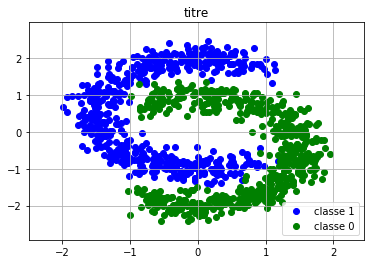

In [19]:
x= two_moons
net3 = neural_net(2,2,10)
net3.train(x,2,0.5)
net3.plot_function(x,"titre")

-6. As a second step, copy your existing implementation to modify it to a new
implementation that will use matrix calculus (instead of a loop) on batches
of size K to improve efficiency. Take the matrix expressions in numpy
derived in the first part, and adapt them for a minibatch of size
K. Show in your report what you have modified (precise the
former and new expressions with the shapes of each matrices).

-7. Compare both implementations (with a loop and with matrix calculus)
to check that they both give the same values for the gradients on the
parameters, first for K = 1, then for K = 10. Display the gradients for
both methods.

In [ ]:
np.array((2,3,4))

-8. Time how long takes an epoch on MNIST (1 epoch = 1 full traversal
through the whole training set) for K = 100 for both versions (loop over
a minibatch and matrix calculus).

-9. Adapt your code to compute the error (proportion of misclassified examples)
on the training set as well as the total loss on the training set during each
epoch of the training procedure, and at the end of each epoch, it computes
the error and average loss on the validation set and the test set. Display
the 6 corresponding figures (error and average loss on train/valid/test),
and write them in a log file.

-10. Train your network on the MNIST dataset. Plot the training/valid/test
curves (error and loss as a function of the epoch number, corresponding
to what you wrote in a file in the last question). Include in your report
the curves obtained using your best hyperparameters, i.e. for which you
obtained your best error on the validation set. We suggest 2 plots : the
first one will plot the error rate (train/valid/test with different colors,
precise which color in a legend) and the other one for the averaged loss
(on train/valid/test). You should be able to get less than 5% test error.
Indicate the values of your best hyperparameters corresponding to the
curves. Bonus points are given for a test error of less that 2%.